In [26]:
import os
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import os; import glob; import cv2
from scipy import ndimage, misc
from scipy.ndimage import maximum_filter, label, find_objects
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize, binary_dilation
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from natsort import natsorted
from sklearn.cluster import DBSCAN
import scipy.io as sio
import skimage.io as io
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


In [2]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

In [3]:
def get_largest_components(binary_mask, n=1):

    # Label connected components
    labeled_mask, num_features = label(binary_mask, return_num=True, connectivity=2)
    
    # Extract properties of labeled regions
    properties = regionprops(labeled_mask)
    
    # Sort regions by area (size) in descending order
    sorted_regions = sorted(properties, key=lambda x: x.area, reverse=True)
    
    # Create an empty mask for the largest components
    largest_components_mask = np.zeros_like(binary_mask)
    
    # Iterate over the top n regions and add them to the mask
    for i in range(min(n, len(sorted_regions))):
        largest_components_mask[labeled_mask == sorted_regions[i].label] = 1
   
    return largest_components_mask

In [4]:
# Address where all raw images are
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse1_2secPerTP_5min');
file_name = 'div2cortex_C1_timelapse1_2secPerTP_5min_jttr_blch_corr.tiff'
resolution = 2.7778    #px./um
frame_interval = 2.00068   #s/frame.

image_path = data_folder+'\\'+file_name
img = tiff.imread(image_path) 

of_path = data_folder+'\\Op_flow'
of_list = natsorted(os.listdir(of_path))
# mask = sio.loadmat(data_folder +'\\cell_mask.mat')['binary_mask']   # if want to use the raw cell mask
mask = sio.loadmat(data_folder +'\\neural_mask.mat')['neural_mask']

mask = mask.astype(float)  # Convert the mask to float
mask[mask==0]=np.NaN

n_frames = (len(of_list))  # number of time-frames in the movie
y_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[0]
x_span = np.shape(sio.loadmat(of_path+'\\0.mat')['vy'])[1]

vy_all = np.zeros((n_frames, y_span, x_span))
vx_all = np.zeros((n_frames, y_span, x_span))
rel_all = np.zeros((n_frames, y_span, x_span))
for i in range(len(of_list)):
    matr = sio.loadmat(of_path+'\\'+of_list[i])
    vy_all[i,:,:] = matr['vy']
    vx_all[i,:,:] = matr['vx']
    rel_all[:,:,:] = matr['rel']
 
# kernel_size was 11 earlier

In [5]:
vel_all = np.sqrt(vx_all**2+vy_all**2)

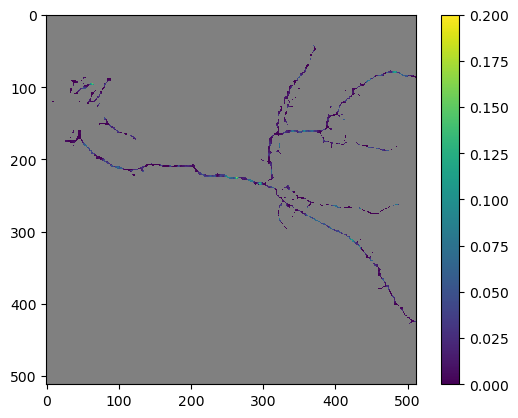

In [45]:
# Create a masked array for NaN values
masking_mat = (vel_all>np.percentile(vel_all, 90)) * (rel_all > np.percentile(rel_all, 90))
mean_mask = (np.nanmean(masking_mat, axis=0))* mask

# Choose a colormap and set NaN values to be displayed in grey
cmap = plt.cm.viridis  # You can choose any colormap you like
cmap.set_bad(color='grey')  # Set color for NaN values

# Mask NaN values
masked_array = np.ma.masked_invalid(mean_mask)

# Plot the result
plt.imshow(masked_array, vmax = 0.20, cmap=cmap)
plt.colorbar()
plt.show()


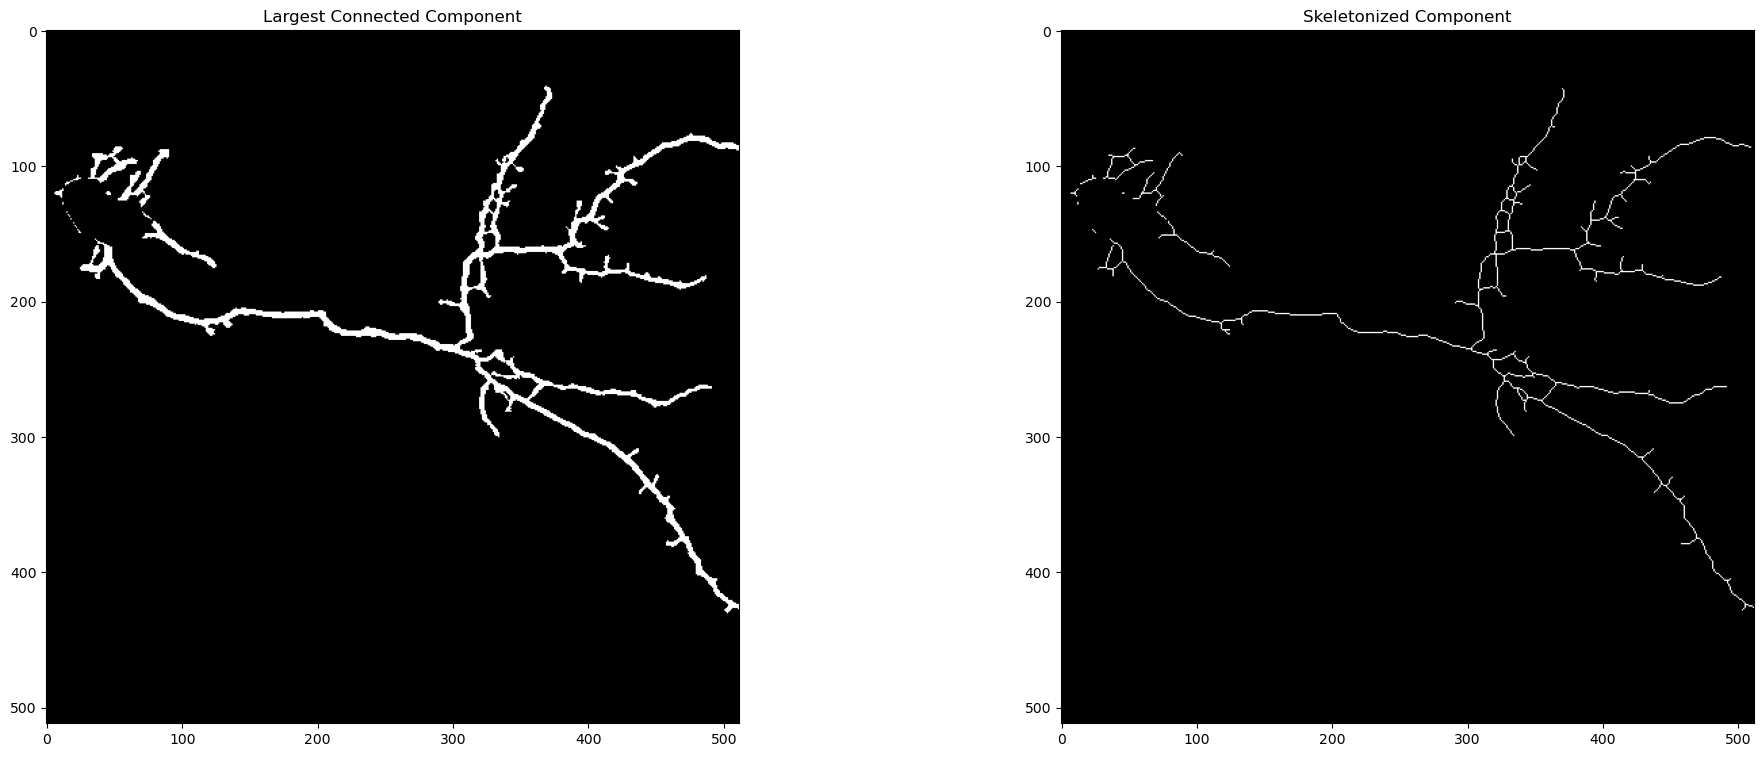

In [47]:
def skeletonize_component(binary_mask, n):

    largest_component = get_largest_components(binary_mask,n)  # Get the largest connected component
    skeleton = skeletonize(largest_component)       # Skeletonize the largest component   
    
    return skeleton

# Convert NaN to 0
mask_without_nan = np.nan_to_num(mask, nan=0)
skeleton = skeletonize_component(mask_without_nan, 10)   # Skeletonize the largest connected component

# Display the original, largest component, and skeletonized images
fig, ax = plt.subplots(1, 2, figsize=(24, 9))

ax[0].imshow(get_largest_components(mask_without_nan,n), cmap='gray')
ax[0].set_title('Largest Connected Component')
ax[1].imshow(skeleton, cmap='gray')
ax[1].set_title('Skeletonized Component')

plt.show()

Number of final clusters after distance thresholding: 6


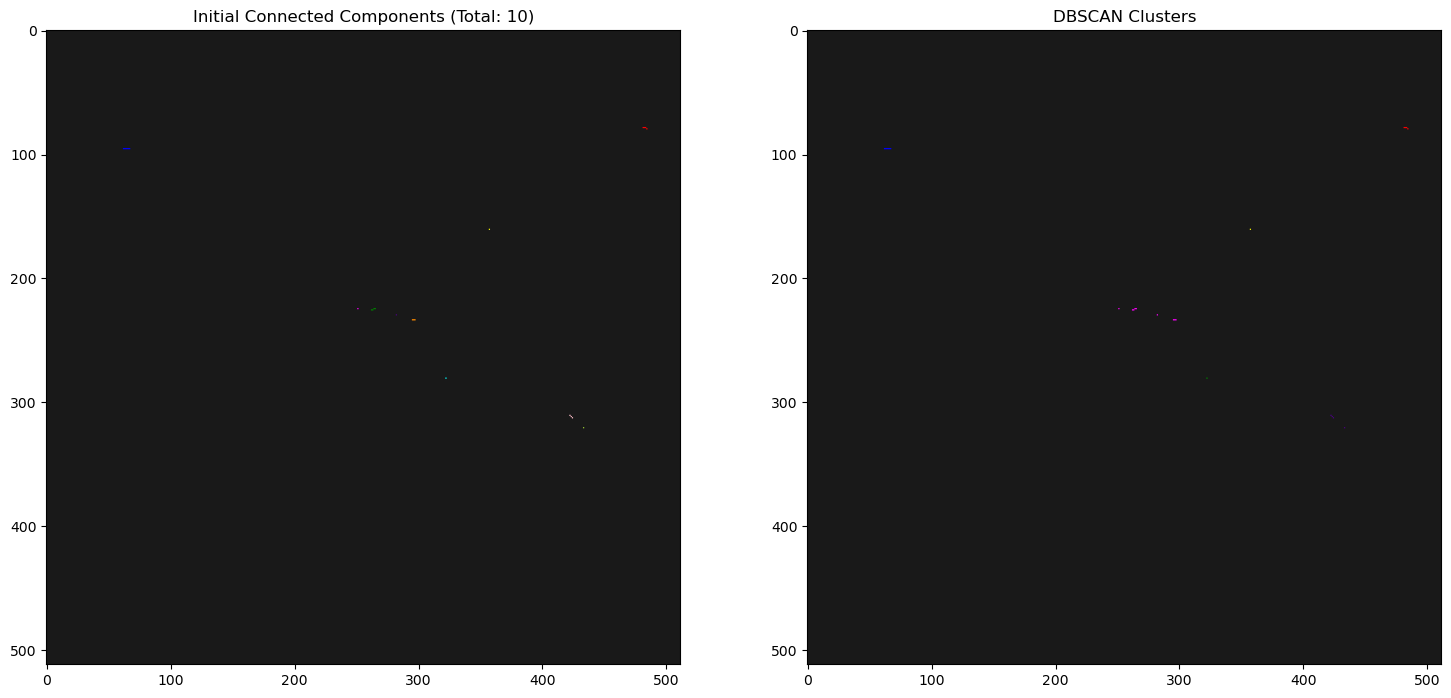

In [51]:
thresh = 0.1
final_mask = skeleton*(mean_mask>thresh)==1

# Example binary mask (replace with your actual binary mask)
binary_mask = final_mask

# Step 1: Label connected components (clusters)
labeled_mask, num_clusters = label(binary_mask, connectivity=2, return_num=True)

# Step 2: Find centroids of the connected components
properties = regionprops(labeled_mask)
centroids = np.array([prop.centroid for prop in properties])

# Step 3: Use DBSCAN for distance-based clustering of centroids
# eps: maximum distance between two centroids to be considered in the same cluster
# min_samples: minimum number of centroids in a neighborhood to form a cluster
db = DBSCAN(eps=50, min_samples=1).fit(centroids)
cluster_labels = db.labels_

# Step 4: Count the number of unique clusters (excluding noise labeled as -1)
n_final_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Number of final clusters after distance thresholding: {n_final_clusters}')

# Step 5: Map the DBSCAN cluster labels back to the mask
# Initialize a new mask for the DBSCAN clusters
dbscan_mask = np.zeros_like(labeled_mask)

for cluster_num in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_num)[0]
    for idx in cluster_indices:
        dbscan_mask[labeled_mask == properties[idx].label] = cluster_num + 1

# Step 6: Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

# Labeled connected components
# Change the background color to light gray (e.g., (0.9, 0.9, 0.9) in RGB format)
colored_components = label2rgb(labeled_mask, bg_label=0, bg_color=(0.1, 0.1, 0.1))
ax[0].imshow(colored_components)
ax[0].set_title(f'Initial Connected Components (Total: {num_clusters})')

# DBSCAN-clustered mask
colored_dbscan = label2rgb(dbscan_mask, bg_label=0, bg_color=(0.1, 0.1, 0.1))
ax[1].imshow(colored_dbscan)
ax[1].set_title(f'DBSCAN Clusters')

plt.show()
